# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN is a clustering algorithm particularly useful for datasets with irregular shapes and noise. Unlike K-means, it does not require you to pre-specify the number of clusters. Instead, it groups points based on **density**: regions of high density form clusters, while sparse regions are treated as noise.

---

## Intuition

The core idea of DBSCAN is that a cluster is a **dense region of points** separated by areas of lower density.

It categorizes points into three types:

* **Core Points**: Points with at least `minPts` neighbors within a distance `ε`.
* **Border Points**: Points that are within the neighborhood of a core point but have fewer than `minPts` themselves.
* **Noise Points**: Points that are not reachable from any core point.

![DBSCAN intuition with core, border, and noise points](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/800px-DBSCAN-Illustration.svg.png)
*Source: Wikipedia*

---

## Parameters

* **ε (epsilon)**: Maximum distance between two points for them to be considered neighbors.
* **minPts**: Minimum number of neighbors within `ε` for a point to be considered a core point.

---

## Algorithm Steps

1. Pick an unvisited point.
2. If it’s a **core point**, start a new cluster and recursively add all points density-reachable from it.
3. If it’s a **border point**, assign it to an existing cluster (if possible).
4. If it’s **noise**, mark it as such.
5. Repeat until all points are visited.

---

## Mathematical Definition

A point \$q\$ is **directly density-reachable** from \$p\$ if:

$$
\|p - q\| \leq \varepsilon \quad \text{and} \quad |N_\varepsilon(p)| \geq \text{minPts}
$$

where \$N\_\varepsilon(p)\$ is the neighborhood of \$p\$:

$$
N_\varepsilon(p) = \{ q \in D \mid \|p - q\| \leq \varepsilon \}
$$

A point \$q\$ is **density-reachable** from \$p\$ if there exists a chain of points \$p\_1, p\_2, \dots, p\_n\$ with \$p\_1 = p\$ and \$p\_n = q\$, such that each point is directly density-reachable from the previous one.

Two points \$p\$ and \$q\$ are **density-connected** if there exists a point \$o\$ such that both \$p\$ and \$q\$ are density-reachable from \$o\$.

---

## Visual Examples

### DBSCAN vs. K-Means

Unlike K-means, DBSCAN can find clusters of arbitrary shape and handle noise.

![DBSCAN vs K-means clustering](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)
*Source: scikit-learn*

---

### Effect of Parameters

The choice of `ε` and `minPts` drastically affects results.

---

## When to Use DBSCAN

- Arbitrary cluster shapes (not spherical like K-means)
- Handling noise and outliers
- Does not work well in datasets with highly varying densities


## Application to Synthetic Data
- The goal of this notebook is to explore DBSCAN on synthetic data, tune parameters, and compare with other clustering methods

## Generate Synthetic Data
- We will be using `make_moons` and `make_blobs` packages to emphasize the strengths and weakness of certain clustering algorithms. These will create synthetic data

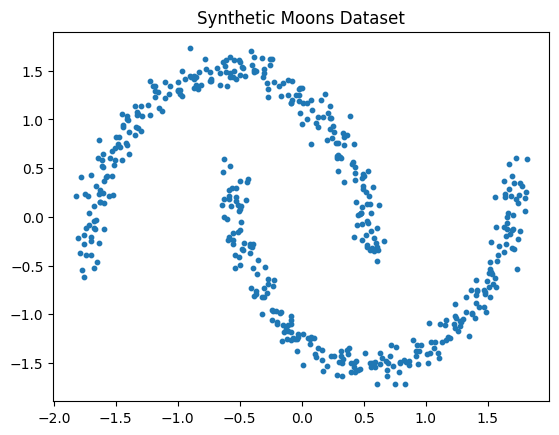

In [1]:
# Standard Imports
import sys
sys.path.append("/Users/rykerdolese/Documents/INDE 577/Data-Science-and-Machine-Learning/src")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
# did not make it into mlpackage
from sklearn.cluster import DBSCAN, KMeans
from mlpackage.preprocess import StandardScaler
from sklearn.metrics import silhouette_score

# Nonlinear "moons" dataset
X_moons, _ = make_moons(n_samples=500, noise=0.05, random_state=42)

# Standardize
X_moons = StandardScaler().fit_transform(X_moons)

plt.scatter(X_moons[:,0], X_moons[:,1], s=10)
plt.title("Synthetic Moons Dataset")
plt.show()

## Applying DBSCAN (First Try)

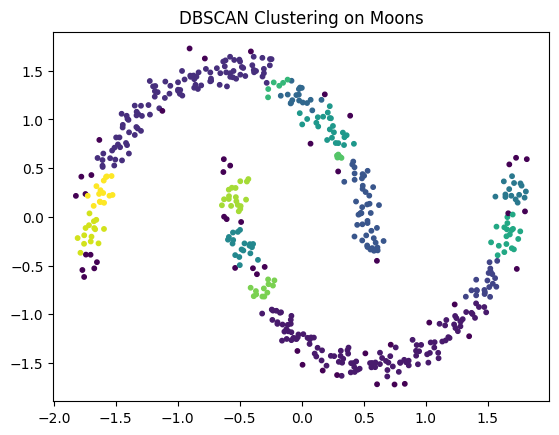

In [2]:
# Create DBSCAN model
# arbitrary eps and min_samples values
db = DBSCAN(eps=0.1, min_samples=5)
labels = db.fit_predict(X_moons)

plt.scatter(X_moons[:,0], X_moons[:,1], c=labels, cmap="viridis", s=10)
plt.title("DBSCAN Clustering on Moons")
plt.show()

The model is identifying the different moon clusters relatively well, but overall needs work. It is identifying more than 2 clusters, which is not ideal.

## Parameter Exploration
- Trying different parameter values to determine how to best capture the two clusters

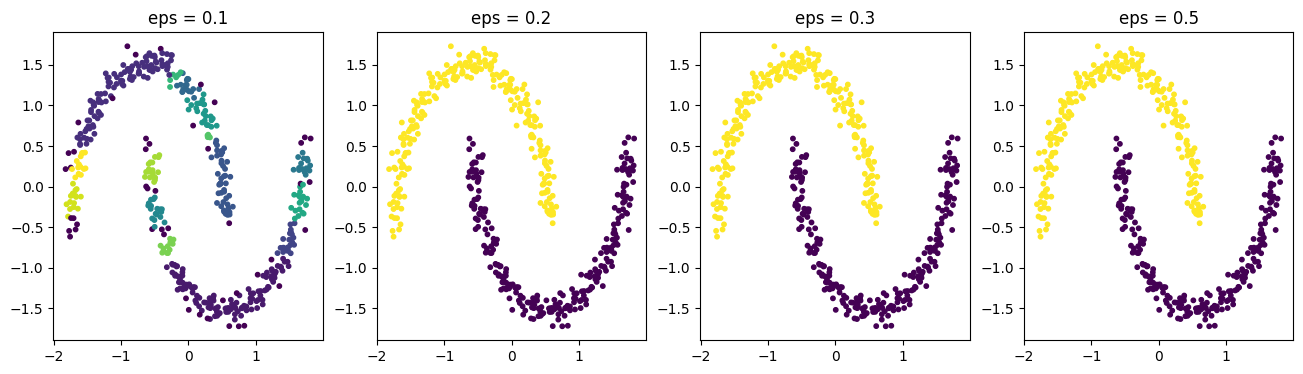

In [3]:
eps_values = [0.1, 0.2, 0.3, 0.5]
fig, axes = plt.subplots(1, len(eps_values), figsize=(16,4))

for i, eps in enumerate(eps_values):
    db = DBSCAN(eps=eps, min_samples=5).fit(X_moons)
    axes[i].scatter(X_moons[:,0], X_moons[:,1], c=db.labels_, cmap="viridis", s=10)
    axes[i].set_title(f"eps = {eps}")

plt.show()


An $\epsilon > 0.1$ seems to work best without creating more than 2 clusters.

## Comparing to K-means

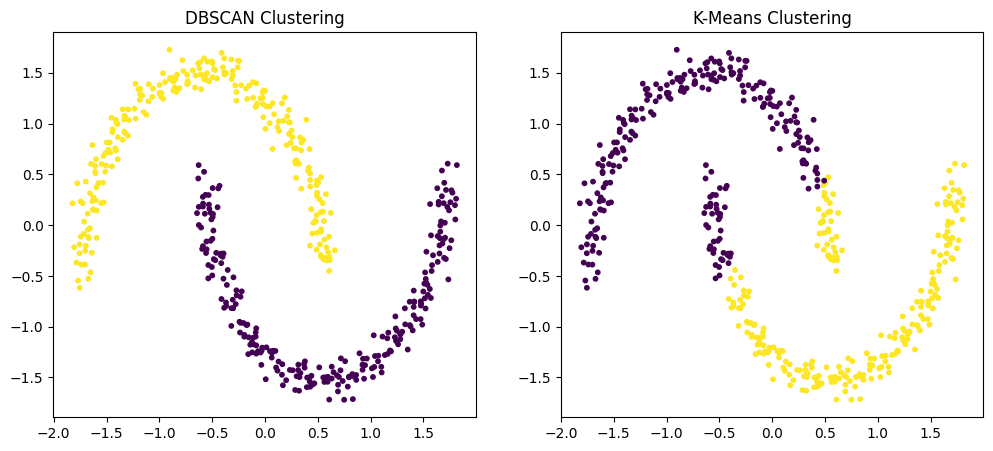

In [4]:
# Our best dbscan model
db = DBSCAN(eps=0.2, min_samples=5)
labels = db.fit_predict(X_moons)

kmeans = KMeans(n_clusters=2, random_state=42)
k_labels = kmeans.fit_predict(X_moons)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(X_moons[:,0], X_moons[:,1], c=labels, cmap="viridis", s=10)
plt.title("DBSCAN Clustering")

plt.subplot(1,2,2)
plt.scatter(X_moons[:,0], X_moons[:,1], c=k_labels, cmap="viridis", s=10)
plt.title("K-Means Clustering")

plt.show()

Even when specifiying just 2 clusters, K-means -- due to it's reliance on a centroid -- splits the two moon-shaped clusters.

## Evaluating our Clustering Algorithm
Here, we are using silhouette score.

In [5]:
sil_db = silhouette_score(X_moons, labels) if len(set(labels)) > 1 else -1
sil_kmeans = silhouette_score(X_moons, k_labels)

print(f"Silhouette Score (DBSCAN): {sil_db:.3f}")
print(f"Silhouette Score (K-Means): {sil_kmeans:.3f}")


Silhouette Score (DBSCAN): 0.389
Silhouette Score (K-Means): 0.496


## Using DBSCAN to Help Identify Outliers
- Another useful application for DBSCAN is to identify outliers that don't belong to any particular cluster
- We will add random noise to our synthetic moon data and try to identify this noise

Correctly identified noise points: 28/40
Missed noise points (absorbed into clusters): 12
False positives (cluster points mislabeled as noise): 1


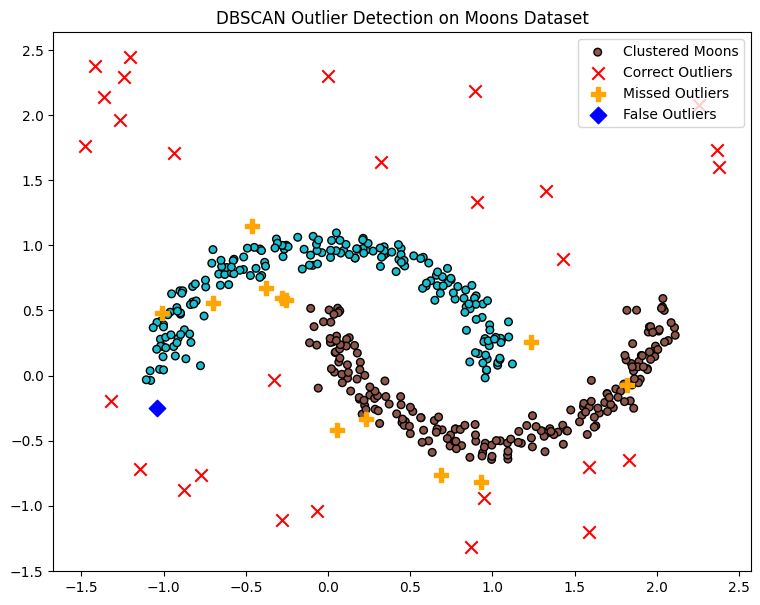

In [6]:
# 1. Generate moons dataset
X_base, y_base = make_moons(n_samples=400, noise=0.07, random_state=42)

# Add uniform random noise (true outliers)
rng = np.random.RandomState(42)
noise = rng.uniform(low=-1.5, high=2.5, size=(40, 2))

X = np.vstack([X_base, noise])
y_true = np.hstack([np.zeros(len(X_base)), np.ones(len(noise))])  # 0 = inlier, 1 = noise

# 2. Fit DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=5)
labels = dbscan.fit_predict(X)

# 3. Evaluate detection of noise
pred_noise = (labels == -1).astype(int)

correctly_identified = np.sum((y_true == 1) & (pred_noise == 1))
missed_noise = np.sum((y_true == 1) & (pred_noise == 0))
false_noise = np.sum((y_true == 0) & (pred_noise == 1))

print(f"Correctly identified noise points: {correctly_identified}/{len(noise)}")
print(f"Missed noise points (absorbed into clusters): {missed_noise}")
print(f"False positives (cluster points mislabeled as noise): {false_noise}")

# 4. Plot clusters with color-coded evaluation
plt.figure(figsize=(9,7))

# Normal clustered points
plt.scatter(X[y_true==0, 0], X[y_true==0, 1], c=labels[y_true==0],
            cmap="tab10", s=30, edgecolor="k", label="Clustered Moons")

# True noise correctly identified
plt.scatter(X[(y_true==1) & (pred_noise==1), 0], 
            X[(y_true==1) & (pred_noise==1), 1], 
            c="red", marker="x", s=80, label="Correct Outliers")

# True noise missed (absorbed into clusters)
plt.scatter(X[(y_true==1) & (pred_noise==0), 0], 
            X[(y_true==1) & (pred_noise==0), 1], 
            c="orange", marker="P", s=90, label="Missed Outliers")

# False positives (true moons mislabeled as noise)
plt.scatter(X[(y_true==0) & (pred_noise==1), 0], 
            X[(y_true==0) & (pred_noise==1), 1], 
            c="blue", marker="D", s=70, label="False Outliers")

plt.title("DBSCAN Outlier Detection on Moons Dataset")
plt.legend()
plt.show()



Overall, our model does a great job in identifying noise, but further tuning could imporve these results further!